## Importation des librairies

In [ ]:
import pulp
import random
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import deque
import pandas as pd
import time
import copy

## Formulation formelle du probl√®me
Le **probl√®me √† r√©soudre** est une version plus complexe du c√©l√®bre **probl√®me du voyageur de commerce (TSP)**.
###  Probl√®me du voyageur de commerce (TSP)

Dans le **TSP**, un vendeur doit visiter un certain nombre de villes **une seule fois chacune**, puis **revenir √† son point de d√©part**, en minimisant la **distance totale parcourue**.


###  Probl√®me de tourn√©es de v√©hicules (VRP)

Le **VRP** (*Vehicle Routing Problem*) est une **g√©n√©ralisation** du TSP.  
Cette fois, il ne s'agit pas d'un seul vendeur, mais de **plusieurs v√©hicules** qui doivent :

- partir d‚Äôun **d√©p√¥t central**,
- visiter un ensemble de **clients** pour effectuer des livraisons ou des ramassages,
- puis **revenir au d√©p√¥t**.

L‚Äôobjectif est d‚Äôorganiser les **tourn√©es de tous les v√©hicules** pour :

- **desservir tous les clients**,  
- **minimiser les co√ªts** (distance, temps, co√ªts...).

## Donn√©es du probl√®me
### Repr√©sentation du graphe

Le syst√®me est mod√©lis√© par un **graphe orient√© et pond√©r√©** : $ G = (V, E) $

avec :
- $ V = \{v_0, v_1, \dots, v_n\} $   Ensemble des **sommets**, repr√©sentant les villes ou les points √† visiter.

- $ E \subseteq V \times V $  Ensemble des **ar√™tes**, repr√©sentant les routes entre les villes.

- Chaque ar√™te $ (v_i, v_j) \in E $ est associ√©e √† trois **attributs** : la **distance** $ d_{ij} \in \mathbb{R}^{+} $, le **co√ªt mon√©taire** $ c_{ij} \in \mathbb{R}^{+} $ et le **temps de trajet** $ t_{ij} \in \mathbb{R}^{+} $.


- Un d√©p√¥t $ v_0 $ (point de d√©part et d‚Äôarriv√©e des tourn√©es)

- Un ensemble de $ k $ v√©hicules, chacun ayant une tourn√©e qui commence et se termine √† $ v_0 $



### Objectif

Trouver un ensemble de $ k $ tourn√©es (une par v√©hicule) telles que :

- Chaque client est visit√© une seule fois par un seul v√©hicule
- Le co√ªt total des tourn√©es est **minimis√©** (ex. : distance, temps et co√ªt total)
- Utilisation de moins de camion possible


### Contraintes

Nous avons choisi d‚Äôint√©grer deux contraintes suppl√©mentaires au probl√®me de base :

1. **Utilisation de plusieurs v√©hicules** : chaque v√©hicule part du d√©p√¥t, visite des clients, puis revient au d√©p√¥t.
2. **Co√ªt ou restriction de passage sur certaines ar√™tes** : certaines routes peuvent avoir un co√ªt plus √©lev√© (par exemple, travaux ou routes bloqu√©es)

## R√©duction polynomiale VRP vers TSP:
Le but de cette partie est de montrer que le VRP peut √™tre r√©duit en temps polynomiale.
- Le TSP consiste √† trouver une tourn√©e unique qui passe par tous les sommets une seule fois. 
- Le VRP consiste √† trouver k tourn√©es, chacune partant et revenant au d√©p√¥t $ v_0 $ , desservant tous les clients

## Repr√©sentation graphique du VRP

Nous avons commenc√© √† mod√©liser notre probl√®me VRP. Pour cela, on a utiliser un code python afin de pouvoir afficher nos graphes sans le respect des contraintes qui sera fait durant le projet

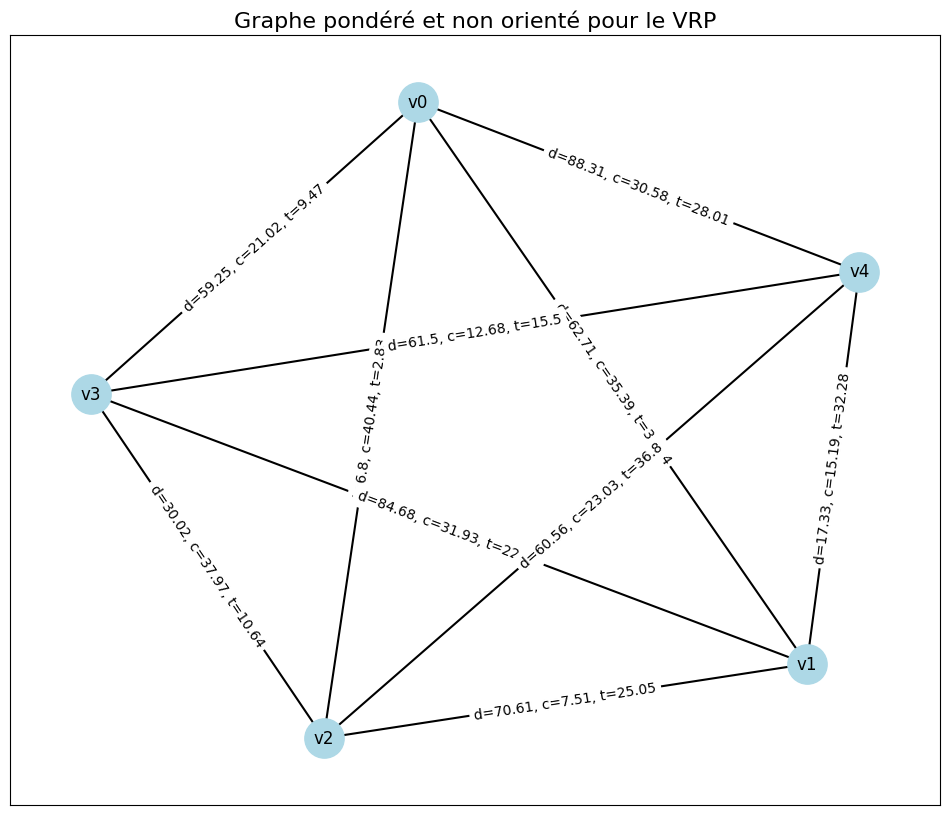

In [5]:
num_clients = 4 
depot = 0
nodes = [depot] + [i for i in range(1, num_clients + 1)]
G = nx.Graph()
for node in nodes:
    G.add_node(node)

for i in nodes:
    for j in nodes:
        if i < j:  
            distance = round(random.uniform(1, 100), 2)  
            cost = round(random.uniform(1, 50), 2)       
            time = round(random.uniform(1, 60), 2)     
            G.add_edge(i, j, distance=distance, cost=cost, time=time)

mapping = {node: f"v{node}" for node in G.nodes}
G = nx.relabel_nodes(G, mapping)
pos = nx.spring_layout(G, seed=42)  
plt.figure(figsize=(12, 10)) 
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
edge_labels = {
    (u, v): f"d={data['distance']}, c={data['cost']}, t={data['time']}"
    for u, v, data in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.title("Graphe pond√©r√© et non orient√© pour le VRP", fontsize=16)
plt.show()


### Transformation du VRP en TSP

Pour transformer le VRP en TSP, **on cr√©e ùëò copies du d√©p√¥t dans le graphe**. Ces copies repr√©sentent **les ùëò tourn√©es distinctes du VRP**. En attribuant des co√ªts tr√®s √©lev√©s entre ces copies, on emp√™che le TSP de relier plusieurs d√©p√¥ts dans une m√™me boucle. Chaque copie devient ainsi le d√©part et l‚Äôarriv√©e d‚Äôune tourn√©e sp√©cifique, simulant l‚Äôutilisation de ùëò v√©hicules dans le TSP.
Plusieurs contraintes sont respect√©s pour les poids des aretes
- Les distances entre les clients sont conserv√©es
- Les distances entre les copies du d√©p√¥t sont fix√©es √† **une grande valeur ùëÄ** pour d√©courager le passage direct entre ces copies
-Les distances entre chaque copie du d√©p√¥t $v_0^{(i)}$ et les clients sont √©gales √† celles du d√©p√¥t original $v_0$ dans l‚Äôinstance VRP.


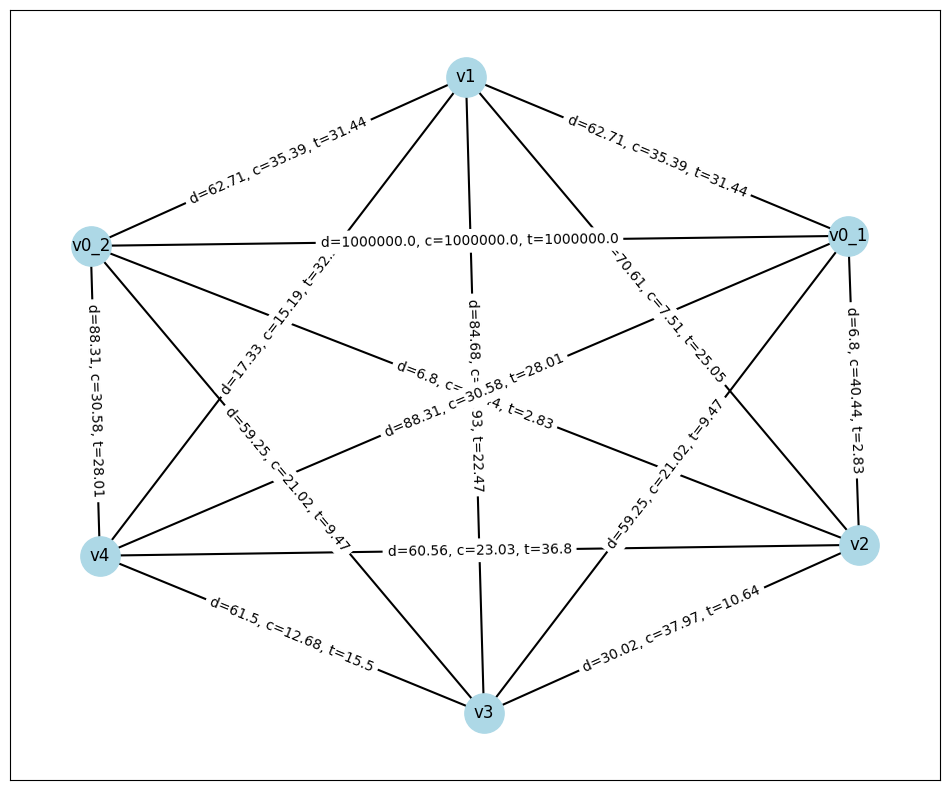

In [6]:
nombre_camion = 2
for i in range(1, nombre_camion + 1):
    depot_copy = f"v0_{i}"
    G.add_node(depot_copy)
    for node in G.nodes:
        if node != depot_copy and not node.startswith("v0_"):  
            original_edge = G.get_edge_data("v0", node)
            if original_edge:
                G.add_edge(depot_copy, node, **original_edge)

for i in range(1, nombre_camion + 1):
    for j in range(i + 1, nombre_camion + 1):
        G.add_edge(f"v0_{i}", f"v0_{j}", distance=1e6, cost=1e6, time=1e6)

if G.has_node("v0"):
    G.remove_node("v0")

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
edge_labels = {
    (u, v): f"d={data['distance']}, c={data['cost']}, t={data['time']}"
    for u, v, data in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.show()

###  Conclusion sur la complexit√© du VRP

Le **Vehicle Routing Problem (VRP)** est une **g√©n√©ralisation** du **probl√®me du voyageur de commerce (TSP)**.

Nous avons montr√© qu‚Äôune instance de VRP peut √™tre transform√©e en une instance **√©quivalente de TSP en temps polynomial**, notamment en **dupliquant le d√©p√¥t** et en **modifiant les co√ªts** du graphe.

Or, le **TSP est un probl√®me NP-complet**, ce qui signifie qu‚Äôil **n‚Äôexiste pas d‚Äôalgorithme polynomial connu** permettant de le r√©soudre efficacement dans tous les cas.

Cette r√©duction polynomiale montre donc que le VRP est lui aussi **NP-complet**, car **il est au moins aussi complexe que le TSP**.


### G√©n√©ration des instances al√©atoires

In [7]:
def generate_weight(restricted_edge, distance_range, time_range):
    if random.random() < restricted_edge: distance = 999
    else: distance = random.randint(*distance_range)
    if random.random() < restricted_edge: time = 999
    else: time = random.randint(*time_range)
    return distance, time

def generate_graph(n, restricted_edge=0.1, distance_range=(1, 100), time_range=(1, 60)):
    G = nx.complete_graph(n)
    for u, v in G.edges():
        distance, time = generate_weight(restricted_edge, distance_range, time_range)
        G[u][v]['distance'] = distance
        G[u][v]['time'] = time
    return G

In [8]:
def draw_graph(G, routes=None, depot=0, title="Graphe complet g√©n√©r√© al√©atoirement"):
    pos = nx.spring_layout(G, seed=42)
    # edge_labels = {(u, v): f"D:{G.edges[u, v]['distance']}, T:{G.edges[u, v]['time']}" for u, v in G.edges}
    edge_labels = {(u, v): G.edges[u, v]['distance'] for u, v in G.edges}

    plt.figure(figsize=(8, 5))
    plt.title(title)
    nx.draw_networkx_nodes(G, pos, node_color=['lightgreen' if n == depot else 'lightblue' for n in G.nodes], node_size=250)
    nx.draw_networkx_labels(G, pos, font_size=7)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    if routes:
        line_color = ["red", "blue", "green", "orange", "purple"]
        for k, edges in enumerate(routes):
            nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.5, edge_color=line_color[k % len(line_color)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.show()

In [9]:
seed = random.randint(0, 100000)
random.seed(seed)
print(f"Seed : {seed}")

Seed : 35531


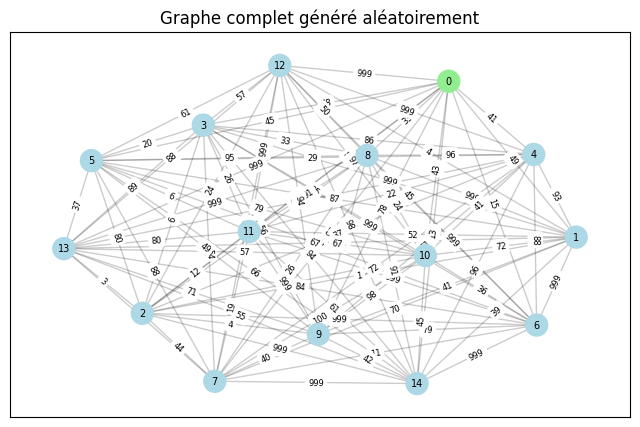

In [10]:
N = 15
G = generate_graph(N)
draw_graph(G)

# Mod√©lisation lin√©aire du probl√®me de tourn√©es de v√©hicules pour minimiser la distance (VRP)

Ce mod√®le lin√©aire permet de r√©soudre un probl√®me de tourn√©es de v√©hicules, o√π plusieurs camions partent d‚Äôun d√©p√¥t, visitent des clients, puis reviennent au d√©p√¥t.  
L‚Äôobjectif est de **minimiser la distance totale parcourue** tout en respectant certaines contraintes.


##  Donn√©es du probl√®me

Le syst√®me est mod√©lis√© par un **graphe orient√© pond√©r√©** $G = (V, E)$ :

- $V = \{v_0, v_1, ..., v_n\}$ : ensemble des sommets, repr√©sentant les clients √† visiter.  
- $v_0$ d√©signe le **d√©p√¥t** (point de d√©part et d‚Äôarriv√©e).
- $E \subseteq V \times V$ : ensemble des ar√™tes dirig√©es (routes).
- Chaque ar√™te $(i, j) \in E$ est associ√©e √† une **distance** $d_{ij} \in \mathbb{R}^+$.
- $k$ : nombre de v√©hicules disponibles.


##  Variables de d√©cision

- $x_{ij} \in \{0, 1\}$ : 1 si l‚Äôar√™te $(i, j)$ est emprunt√©e par un v√©hicule, 0 sinon.

- $u_i \in \mathbb{Z}$ : variable auxiliaire pour √©liminer les sous-tours (formulation MTZ), d√©finie pour tous les $i \in \{1, ..., n\}$.



##  Fonction objectif

Minimiser la **distance totale parcourue** :

$$
\min \sum_{(i,j) \in E} d_{ij} \cdot x_{ij}
$$


##  Contraintes

### 1. Visite unique de chaque client

Chaque client doit √™tre visit√© **exactement une fois** :

$$
\sum_{i \in V,\, i \ne j} x_{ij} = 1 \quad \forall j \in V 
$$

$$
\sum_{j \in V,\, j \ne i} x_{ij} = 1 \quad \forall i \in V 
$$


### 2. Utilisation du d√©p√¥t

Le d√©p√¥t $v_0$ est utilis√© par exactement $k$ v√©hicules :

$$
\sum_{j \in V } x_{0j} = k
$$

$$
\sum_{i \in V} x_{i0} = k
$$



### 3. √âlimination des sous-tours (MTZ)

Pour √©viter la cr√©ation de cycles ne passant pas par le d√©p√¥t :

$
1 \le u_i \le n \quad \forall i \in V 
$
$
u_i - u_j + n \cdot x_{ij} \le n - 1 \quad \forall i \ne j,\ i,j \in V
$

##  Interpr√©tation

Ce mod√®le permet de :

- Planifier les tourn√©es de $k$ v√©hicules partant et revenant au d√©p√¥t $v_0$
- Assurer la visite unique de chaque client
- √âviter les cycles internes sans passer par le d√©p√¥t
- **Minimiser la distance totale** pour un impact √©conomique et √©cologique r√©duit

In [11]:
def solve_distance_vrp(G, K, depot=0):
    customers = [v for v in G.nodes if v != depot]      # Sommets √† visiter
    m = len(customers)                                  # Nombre de clients
    L = m // K                                          # Nombre minimum de clients par camion
    U = L if m % K == 0 else L + 1                      # Nombre maximum de clients par camion

    arcs = [(i, j) for i in G.nodes for j in G.nodes if i != j]

    # --- D√©finir le probl√®me --- #
    prob = pulp.LpProblem("Distance_VRP", pulp.LpMinimize)

    # --- Variables de d√©cision --- #
    # x[i,j,k] = 1 si le camion k prend l'arc (i,j), 0 sinon
    # u[i,k] = Nombre de clients visit√©s par le camion k avant le client i
    x = pulp.LpVariable.dicts("x", ((i, j, k) for (i, j) in arcs for k in range(K)), lowBound=0, upBound=1, cat="Binary")
    u = pulp.LpVariable.dicts("u", ((i, k) for i in customers for k in range(K)), lowBound=1, upBound=m, cat="Integer")

    # --- Fonction objectif : minimiser la distance totale parcourue --- #
    prob += pulp.lpSum(G.edges[i, j]["distance"] * x[(i, j, k)] for (i, j) in arcs for k in range(K))

    # --- Contraintes --- #
    # Chaque client exactement une fois
    for i in customers:
        prob += pulp.lpSum(x[(i, j, k)] for j in G.nodes if j != i for k in range(K)) == 1

    # Un d√©part & un retour d√©p√¥t par camion
    for k in range(K):
        prob += pulp.lpSum(x[(0, j, k)] for j in customers) == 1
        prob += pulp.lpSum(x[(i, 0, k)] for i in customers) == 1

    # Conservation du flux
    for k in range(K):
        for v in customers:
            prob += (pulp.lpSum(x[(i, v, k)] for i in G.nodes if i != v) - pulp.lpSum(x[(v, j, k)] for j in G.nodes if j != v)) == 0

    # MTZ : √©limination des sous-tours
    for k in range(K):
        for i, j in itertools.permutations(customers, 2):
            prob += u[(i, k)] - u[(j, k)] + m * x[(i, j, k)] <= m - 1

    # √âquilibrage (m√™me nombre de clients ¬±1 par camion)
    # L = m // K, U = L + 1 si m % K != 0
    # L <= nombre de clients par camion <= U
    for k in range(K):
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) >= L
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) <= U

    # R√©solution
    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    # R√©cup√©ration des ar√™tes s√©lectionn√©es pour chaque camion
    routes = [[] for _ in range(K)]
    for k in range(K):
        for i, j in arcs:
            if pulp.value(x[(i, j, k)]) > 0.5:
                routes[k].append((i, j))

    return routes, pulp.value(prob.objective)


R√âSUM√â GLOBAL
Distance totale : 353
Temps total     : 2528

Camion      Distance     Temps   Tourn√©e
--------------------------------------
0                151      1321   0 ‚Üí 10 ‚Üí 8 ‚Üí 9 ‚Üí 2 ‚Üí 13 ‚Üí 7 ‚Üí 6 ‚Üí 0
1                202      1207   0 ‚Üí 14 ‚Üí 1 ‚Üí 12 ‚Üí 3 ‚Üí 5 ‚Üí 11 ‚Üí 4 ‚Üí 0


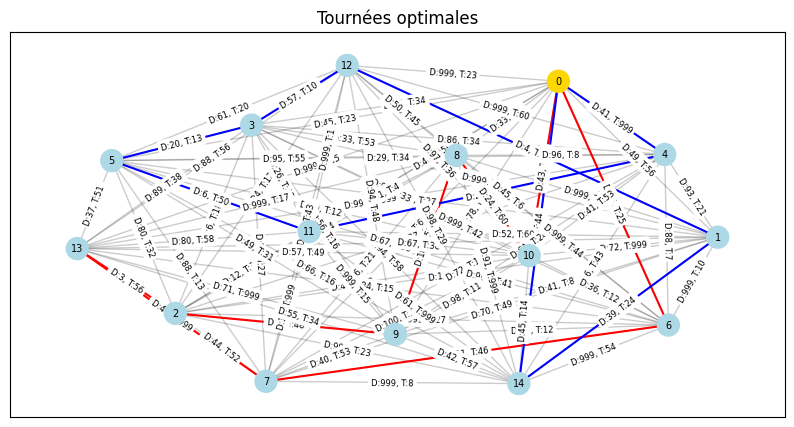

In [12]:
def print_solution_summary(G, routes, depot=0):
    total_distance = sum(G.edges[u, v]['distance'] for edges in routes for u, v in edges)
    total_time = sum(G.edges[u, v]['time'] for edges in routes for u, v in edges)

    print("\n\033[1mR√âSUM√â GLOBAL\033[0m")
    print(f"Distance totale : {total_distance}")
    print(f"Temps total     : {total_time}")

    # En-t√™te du tableau
    header = f"\n\033[1m{'Camion':<8}{'Distance':>12}{'Temps':>10}   Tourn√©e\033[0m"
    print(header)
    print("-" * (len(header) - 11))

    # D√©tail par camion
    for k, edges in enumerate(routes):
        dist = sum(G.edges[u, v]['distance'] for u, v in edges)
        t = sum(G.edges[u, v]['time'] for u, v in edges)

        # --- tentative de reconstruction du chemin dans l'ordre ---
        path = [depot]
        remaining = edges.copy()
        while remaining:
            for idx, (i, j) in enumerate(remaining):
                if i == path[-1]:
                    path.append(j)
                    remaining.pop(idx)
                    break
                elif j == path[-1]:
                    path.append(i)
                    remaining.pop(idx)
                    break
            else:
                # si l'ordre exact n'est pas d√©ductible, on sort
                path.extend([edge for pair in remaining for edge in pair])
                break
        path_str = " ‚Üí ".join(map(str, path))
        print(f"{k:<8}{dist:>12}{t:>10}   {path_str}")

def draw_solution(G, routes, depot=0, title="Tourn√©es optimales"):
    pos = nx.spring_layout(G, seed=42)
    edge_labels = {(u, v): f"D:{G.edges[u, v]['distance']}, T:{G.edges[u, v]['time']}" for u, v in G.edges}

    plt.figure(figsize=(10, 5))
    plt.title(title)
    nx.draw_networkx_nodes(G, pos, node_color=['gold' if n == depot else 'lightblue' for n in G.nodes], node_size=250)
    nx.draw_networkx_labels(G, pos, font_size=7)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    line_color = ["red", "blue", "green", "orange", "purple"]
    for k, edges in enumerate(routes):
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.5, edge_color=line_color[k % len(line_color)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.show()

routes, total_distance = solve_distance_vrp(G, 2)
print_solution_summary(G, routes)
draw_solution(G, routes, title="Tourn√©es optimales")


### M√©ta heuristique
Nous avons fait le choix d'utiliser deux m√©ta heuristiques pour r√©soudre notre probl√®me de tourn√©es de v√©hicules. Ces deux algorithmes sont les suivants :
- **la colonie de fourmis** : qui s'inspire du comportement des fourmis pour trouver le chemin le plus court entre le d√©p√¥t et les clients.
- **la recherche tabou** : qui utilise une m√©moire pour √©viter de revisiter les solutions d√©j√† explor√©es, permettant ainsi d'explorer efficacement l'espace de recherche.

In [13]:
def plot_vrp_solution(graph, routes, depot):
    #dessiner le graphe
    pos = nx.spring_layout(graph, seed=42)  
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'] 
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(graph, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_labels(graph, pos, font_size=12, font_color='black')
    
    #dessiner les ar√™tes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]  
        edges = [(route[j], route[j + 1]) for j in range(len(route) - 1)]
        nx.draw_networkx_edges(graph, pos, edgelist=edges, width=2.5, edge_color=color, label=f'Camion {i + 1}')
    nx.draw_networkx_nodes(graph, pos, nodelist=[depot], node_size=1000, node_color='yellow', label='D√©p√¥t')
    plt.title("Solution VRP avec routes color√©es", fontsize=16)
    plt.legend()
    plt.show()

In [14]:
def ant_colony_vrp_fast(graph, depot, num_vehicles=2, num_ants=10, num_iterations=50, alpha=1, beta=2, evaporation_rate=0.5, pheromone_init=1.0):
    pheromones = {edge: pheromone_init for edge in graph.edges}
    best_routes = None
    best_cost = float('inf')
    nodes = list(graph.nodes)
    nodes.remove(depot)
    nodes_per_vehicle = len(nodes) // num_vehicles
    extra_nodes = len(nodes) % num_vehicles

    courantes = []
    meilleures_courantes = []

    for iteration in range(num_iterations):
        for ant in range(num_ants):
            unvisited = set(graph.nodes)
            unvisited.remove(depot)
            routes = []
            total_cost = 0

            for vehicle in range(num_vehicles):
                current_route = [depot]
                current_node = depot
                visited_this_trip = set()
                nodes_to_visit = nodes_per_vehicle + (1 if vehicle < extra_nodes else 0)

                while unvisited and len(visited_this_trip) < nodes_to_visit:
                    neighbors = [n for n in graph.neighbors(current_node) if n in unvisited]
                    if not neighbors:
                        break

                    probabilities = []
                    for neighbor in neighbors:
                        edge = (current_node, neighbor) if (current_node, neighbor) in pheromones else (neighbor, current_node)
                        pheromone = pheromones[edge]
                        distance = graph[current_node][neighbor]['distance']
                        probabilities.append((neighbor, (pheromone ** alpha) * ((1 / distance) ** beta)))

                    if not probabilities:
                        break

                    total_prob = sum(prob[1] for prob in probabilities)
                    next_node = random.choices(
                        [node for node, _ in probabilities],
                        [prob / total_prob for _, prob in probabilities]
                    )[0]

                    current_route.append(next_node)
                    total_cost += graph[current_node][next_node]['distance']
                    unvisited.remove(next_node)
                    visited_this_trip.add(next_node)
                    current_node = next_node

                if current_node != depot:
                    current_route.append(depot)
                    total_cost += graph[current_node][depot]['distance']

                routes.append(current_route)

            if total_cost < best_cost:
                best_cost = total_cost
                best_routes = routes

        # Sauvegarde des co√ªts √† chaque it√©ration
        courantes.append(total_cost)
        meilleures_courantes.append(best_cost)

        # Mise √† jour des ph√©romones
        for edge in pheromones:
            pheromones[edge] *= (1 - evaporation_rate)

        for route in best_routes:
            for i in range(len(route) - 1):
                edge = (route[i], route[i + 1]) if (route[i], route[i + 1]) in pheromones else (route[i + 1], route[i])
                pheromones[edge] += 1 / best_cost

    return best_routes, best_cost, courantes, meilleures_courantes

### Recherche tabou

In [15]:
def smart_initial_solution(graph, nombre_camion, depot):
    nodes = list(graph.nodes())
    nodes.remove(depot)
    
    # Trier les villes par distance au d√©p√¥t
    nodes.sort(key=lambda node: graph[depot][node]['distance'] if graph.has_edge(depot, node) else graph[node][depot]['distance'])
    
    split = [len(nodes) // nombre_camion] * nombre_camion
    for i in range(len(nodes) % nombre_camion):
        split[i] += 1
    
    solution = []
    idx = 0
    for s in split:
        route = [depot] + nodes[idx:idx+s] + [depot]
        idx += s
        solution.append(route)
    return solution

def calculate_cost(graph, solution):
    total_cost = 0
    for route in solution:
        for i in range(len(route) - 1):
            u, v = route[i], route[i+1]
            if graph.has_edge(u, v):
                total_cost += graph[u][v]['distance']
            elif graph.has_edge(v, u):
                total_cost += graph[v][u]['distance']
            else:
                total_cost += 9999  # p√©nalit√© √©norme
    return total_cost

def tabu_search(graph, nombre_camion, depot=0, iterations=500, tabu_tenure=15):
    solution = smart_initial_solution(graph, nombre_camion, depot)
    best_solution = copy.deepcopy(solution)
    best_cost = calculate_cost(graph, best_solution)
    tabu_list = []
    
    # Pour suivre l'√©volution des co√ªts
    courantes = []
    meilleures_courantes = []

    for _ in range(iterations):
        neighborhood = []
        for i in range(nombre_camion):
            for j in range(1, len(solution[i]) - 1):
                for k in range(nombre_camion):
                    if i != k:
                        for l in range(1, len(solution[k]) - 1):
                            neighbor = copy.deepcopy(solution)
                            neighbor[i][j], neighbor[k][l] = neighbor[k][l], neighbor[i][j]
                            if neighbor not in tabu_list:
                                neighborhood.append((neighbor, calculate_cost(graph, neighbor)))
        
        if not neighborhood:
            break
        
        neighborhood.sort(key=lambda x: x[1])
        solution, current_cost = neighborhood[0]

        # Mise √† jour de la meilleure solution rencontr√©e
        if current_cost < best_cost:
            best_solution = copy.deepcopy(solution)
            best_cost = current_cost

        tabu_list.append(solution)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        courantes.append(current_cost)
        meilleures_courantes.append(best_cost)

    return best_solution, best_cost, courantes, meilleures_courantes

## Comparaison des r√©sultats:

### Test sur plusieurs instances pour √©valuer la performance des algorithmes

R√©sulat pour la colonie de fourmi

In [16]:
def run_optimization_algorithm_ant(algorithm, graph, num_vehicles, depot=0, iterations=500, tabu_tenure=15, **kwargs):
    """
    Fonction g√©n√©rique pour ex√©cuter un algorithme d'optimisation comme Tabou ou Fourmis.
    """
    best_solution, best_cost, courantes, meilleures_courantes = algorithm(
        graph, depot=depot, num_vehicles=num_vehicles, num_iterations=iterations, **kwargs
    )

    plt.xlabel("Nombre d'it√©rations", fontsize=16)
    plt.ylabel("Co√ªt total", fontsize=16)
    plt.plot(range(len(courantes)), courantes, label="Co√ªt courant", color='blue')
    plt.plot(range(len(meilleures_courantes)), meilleures_courantes, label="Meilleur co√ªt global", color='red')
    plt.legend()
    plt.title(f"√âvolution des co√ªts pour l'algorithme {algorithm.__name__}")
    plt.show()

    return best_solution, best_cost, courantes, meilleures_courantes

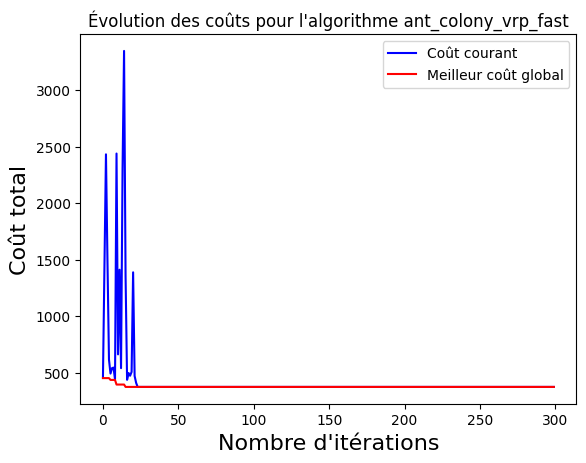

In [17]:
best_routes, best_cost, courantes, meilleures_courantes = run_optimization_algorithm_ant(
    ant_colony_vrp_fast,
    G,
    num_vehicles=2,
    depot=0,
    iterations=300,         # num_iterations pour colonie de fourmis
    num_ants=20,            # param√®tres suppl√©mentaires via **kwargs
    alpha=1.5,
    beta=2,
    evaporation_rate=0.3
)

R√©sultat pour la recherche tabou :

In [18]:
def run_optimization_algorithm_tabou(algorithm, graph, num_vehicles, depot=0, iterations=500, tabu_tenure=15):
    """
    Fonction g√©n√©rique pour ex√©cuter un algorithme d'optimisation comme la recherche Tabou ou la colonie de fourmis.
    
    Args:
    - algorithm: fonction repr√©sentant l'algorithme √† utiliser (par exemple `tabu_search` ou `ant_colony_optimization`).
    - graph: le graphe sur lequel l'optimisation doit √™tre effectu√©e.
    - num_vehicles: nombre de v√©hicules.
    - depot: index du d√©p√¥t.
    - iterations: nombre d'it√©rations.
    - tabu_tenure: tenure de la liste Tabou (utile pour la recherche Tabou).
    
    Returns:
    - best_solution: la meilleure solution trouv√©e.
    - best_cost: le co√ªt de la meilleure solution.
    - courantes: la liste des co√ªts √† chaque it√©ration.
    - meilleures_courantes: la liste des meilleurs co√ªts globaux √† chaque it√©ration.
    """
    best_solution, best_cost, courantes, meilleures_courantes = algorithm(graph, num_vehicles, depot, iterations, tabu_tenure)

    # Tracer l'√©volution des co√ªts
    plt.xlabel("Nombre d'it√©rations", fontsize=16)
    plt.ylabel("Co√ªt total", fontsize=16)
    plt.plot(range(len(courantes)), courantes, label="Co√ªt courant", color='blue')
    plt.plot(range(len(meilleures_courantes)), meilleures_courantes, label="Meilleur co√ªt global", color='red')
    plt.legend()
    plt.title(f"√âvolution des co√ªts pour l'algorithme {algorithm.__name__}")
    plt.show()

    return best_solution, best_cost, courantes, meilleures_courantes

In [23]:
iterations = 300  # Nombre d'it√©rations
tabu_tenure = 20  # Tenure de la liste Tabou
seed = 42  # Pour la reproductibilit√©
best_solution, best_cost, courantes, meilleures_courantes = run_optimization_algorithm_tabou(tabu_search, G, nombre_camion, depot=0, iterations=iterations, tabu_tenure=tabu_tenure)

print("Solution trouv√©e :")
for idx, route in enumerate(best_solution):
    print(f" V√©hicule {idx+1} : {route}")
print("Co√ªt total :", best_cost)

plot_vrp_solution(G, routes, depot=0)

NameError: name 'copy' is not defined

In [22]:
def run_iteration_experiment_with_pl(existing_graph, num_vehicles=2, iteration_values=[10, 20, 30, 40, 50, 60]):
    """
    Teste les performances des algorithmes PL, Tabou et Fourmis sur un graphe existant.
    """
    results = {
        'iterations': [],
        'method': [],
        'cost': [],
        'time': []
    }

    for iterations in iteration_values:
        # Utilisation du graphe existant
        G_test = existing_graph

        # === Programmation Lin√©aire (PL) ===
        try:
            start_time = time.time()
            routes_pl, cost_pl = solve_distance_vrp(G_test, num_vehicles, depot=0)
            time_pl = time.time() - start_time
        except:
            routes_pl, cost_pl, time_pl = None, None, None

        if cost_pl is not None:
            results['iterations'].append(iterations)
            results['method'].append('PL')
            results['cost'].append(cost_pl)
            results['time'].append(time_pl)

        # === Recherche Tabou ===
        start_time = time.time()
        best_tabu_solution, best_tabu_cost, _, _ = tabu_search(
            G_test, num_vehicles, depot=0, iterations=iterations, tabu_tenure=15
        )
        time_tabu = time.time() - start_time

        results['iterations'].append(iterations)
        results['method'].append('Tabou')
        results['cost'].append(best_tabu_cost)
        results['time'].append(time_tabu)

        # === Colonie de Fourmis ===
        start_time = time.time()
        best_aco_routes, best_aco_cost, _, _ = ant_colony_vrp_fast(
            G_test, depot=0, num_vehicles=num_vehicles, num_ants=10, num_iterations=iterations
        )
        time_aco = time.time() - start_time

        results['iterations'].append(iterations)
        results['method'].append('Fourmis')
        results['cost'].append(best_aco_cost)
        results['time'].append(time_aco)

    # Organisation des r√©sultats dans un DataFrame
    df_results = pd.DataFrame(results)

    # Calcul des moyennes et √©carts-types
    summary = df_results.groupby(['iterations', 'method']).agg(
        mean_cost=('cost', 'mean'),
        std_cost=('cost', 'std'),
        mean_time=('time', 'mean'),
        std_time=('time', 'std')
    ).reset_index()

    # --- Graphique 1 : Co√ªt moyen ---
    plt.figure(figsize=(10, 6))
    for method in ['Tabou', 'Fourmis', 'PL']:
        if method in summary['method'].values:
            data = summary[summary['method'] == method]
            plt.errorbar(data['iterations'], data['mean_cost'], yerr=data['std_cost'], label=method, capsize=5)
    plt.xlabel('Nombre d\'it√©rations')
    plt.ylabel('Co√ªt moyen')
    plt.title('Comparaison des co√ªts moyens')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Graphique 2 : Temps moyen ---
    plt.figure(figsize=(10, 6))
    for method in ['Tabou', 'Fourmis', 'PL']:
        if method in summary['method'].values:
            data = summary[summary['method'] == method]
            plt.errorbar(data['iterations'], data['mean_time'], yerr=data['std_time'], label=method, capsize=5)
    plt.xlabel('Nombre d\'it√©rations')
    plt.ylabel('Temps moyen (s)')
    plt.title('Comparaison des temps moyens')
    plt.legend()
    plt.grid(True)
    plt.show()

run_iteration_experiment_with_pl(G, num_vehicles=2, iteration_values=[10, 20, 30, 40, 50, 60])

AttributeError: 'float' object has no attribute 'time'

### R√©f√©rences utiles

- https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce
- https://fr.wikipedia.org/wiki/Probl%C3%A8me_de_tourn%C3%A9es_de_v%C3%A9hicules
- Workshop
- https://networkx.org/documentation/stable/reference/introduction.html
- https://www.guru99.com/fr/travelling-salesman-problem.html#:~:text=Le%20probl%C3%A8me%20du%20voyageur%20de%20commerce%20%28TSP%29%20est,fa%C3%A7on%20exponentielle%20avec%20l%E2%80%99augmentation%20du%20nombre%20de%20villes.
- https://github.com/jwang0306/vehicle-routing-problem?tab=readme-ov-file
- https://www.youtube.com/watch?v=GiDsjIBOVoA&list=TLPQMjcwNDIwMjWGmE-QXy8F6w&index=1&pp=gAQBiAQB